# Project : Emotion Detection With FER 2013

This project should be run in kaggle notebook,
* Import this notebook in Kaggle
* In the datasets search for "amaz-basuru-daniel"
* load the datasets
* In "Settings" choose a GPU for faster performance


If you follow these steps the notebook is ready to Go!

loading the Librarires

In [96]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


haars cascade is loaded into the notebook

In [15]:
face_cascade = cv2.CascadeClassifier('/kaggle/input/amaz-basuru-daniel/Assignment03/haarcascades/haarcascade_frontalface_default.xml')

use this function to detect face


In [4]:
def detect_face(img):
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img, minNeighbors=1) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_img
    

reading an Image

In [5]:
def turn_to_gray(im_path):
    image = cv2.imread(im_path) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


In [16]:
from pathlib import Path

root = Path("/kaggle/input/amaz-basuru-daniel/Assignment03/data/train/angry")

image_names = ["Training_63181.jpg","Training_9402163.jpg","Training_99531165.jpg","Training_81730099.jpg", "Training_8861363.jpg"]
image_paths = []

for item in image_names:
    image_path = root / item  
    image_paths.append(image_path)

print(image_paths)


[PosixPath('/kaggle/input/amaz-basuru-daniel/Assignment03/data/train/angry/Training_63181.jpg'), PosixPath('/kaggle/input/amaz-basuru-daniel/Assignment03/data/train/angry/Training_9402163.jpg'), PosixPath('/kaggle/input/amaz-basuru-daniel/Assignment03/data/train/angry/Training_99531165.jpg'), PosixPath('/kaggle/input/amaz-basuru-daniel/Assignment03/data/train/angry/Training_81730099.jpg'), PosixPath('/kaggle/input/amaz-basuru-daniel/Assignment03/data/train/angry/Training_8861363.jpg')]


visualizing it 

In [17]:
detections = []
for item in image_paths:
    gray = turn_to_gray(item)
    det = detect_face(gray)
    detections.append(det)

calling the detect function

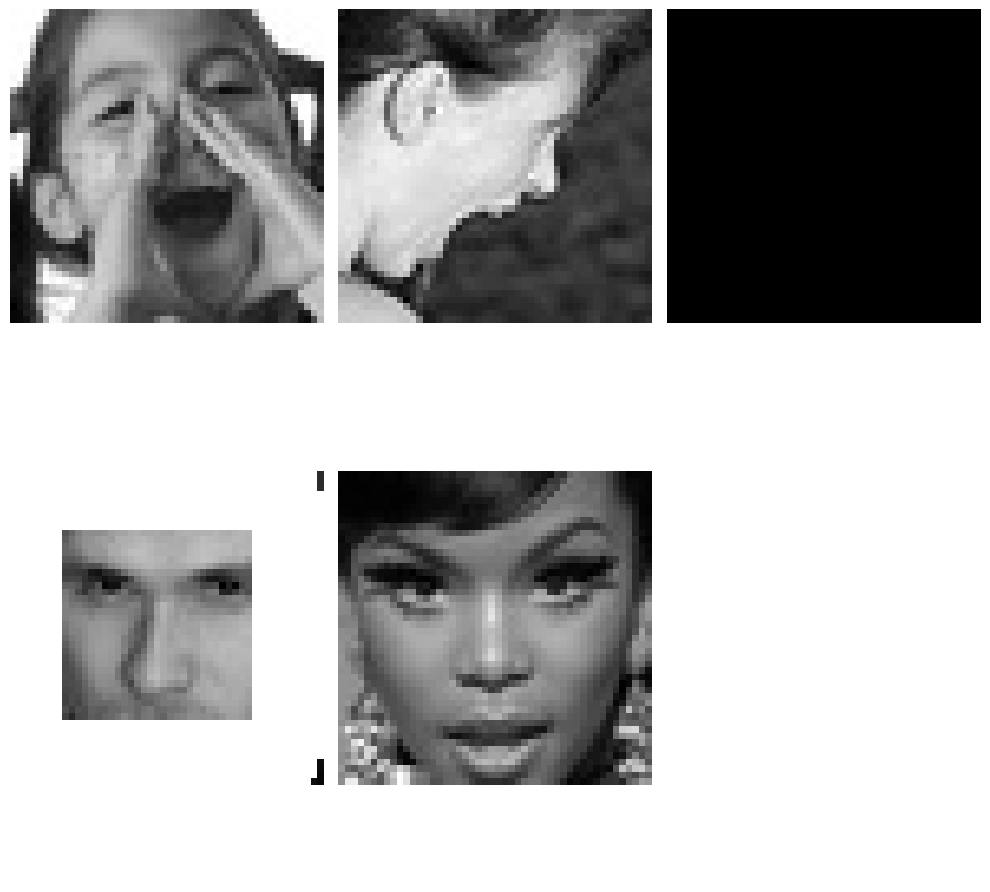

In [18]:
import matplotlib.pyplot as plt

num_images = len(detections)
cols = 3 
rows = (num_images + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for ax, img in zip(axes.flat, detections):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

for ax in axes.flat[len(detections):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Out of all the images chosen only one was detected as a face, first image with the girl covering her face and the second image with the man who has his face turned and the black image are all bad data, however thw woman in the final image is good data , but the haars cascade hasn't detected this properly. 

However, the fourth image has been detected properly

Use this function to crop the images

In [19]:
def crop_bbox(img, x, y, w, h, pad=0):
    H, W = img.shape[:2]
    x1 = max(0, x - pad)
    y1 = max(0, y - pad)
    x2 = min(W, x + w + pad)
    y2 = min(H, y + h + pad)
    return img[y1:y2, x1:x2]

In [20]:
def detect_face(img, minN):
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img, minNeighbors=minN) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_rects

In [21]:
def detect_faces_robust(img_bgr,scaleFactor=1.08, minNeighbors=1, minSize=(18,18),clahe=True, upsample_if_small=True):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if clahe:
        gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4)).apply(gray)
    scale_back = 1.0
    if upsample_if_small and (gray.shape[0] < 200 or gray.shape[1] < 200):
        gray = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
        scale_back = 0.5
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors,minSize=minSize, flags=cv2.CASCADE_SCALE_IMAGE)

    boxes = []
    for (x,y,w,h) in faces:
        if scale_back != 1.0:
            x = int(x*scale_back); y = int(y*scale_back)
            w = int(w*scale_back); h = int(h*scale_back)
        boxes.append((x,y,w,h))
    return boxes

In [22]:
import os,csv
from tqdm import tqdm

def filter_dataset_with_haar(in_root, out_root,resize_to=(48,48), pad=4, keep_largest_only=True,  
    save_rejects=True, rejects_subdir="_rejects", force_grayscale=True, write_manifest=True):
    in_root  = Path(in_root)
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)
    rej_root = out_root / rejects_subdir    
    if save_rejects:
        rej_root.mkdir(parents=True, exist_ok=True)

    kept, rejected = 0, 0

    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    img_paths = [p for p in in_root.rglob("*") if p.suffix.lower() in exts]
    for p in tqdm(img_paths, desc="Filtering"):
        
        rel = p.relative_to(in_root)
        label = rel.parent.name 
        img = cv2.imread(str(p))
        if img is None: 
            rejected += 1
            continue
        boxes = detect_faces_robust(img)  
        if not boxes:
            rejected += 1
            if save_rejects:
                (rej_root/label).mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str((rej_root/label/f"{p.stem}_noface{p.suffix}")), img)
            continue
        sel = boxes
        if keep_largest_only:
            sel = [max(boxes, key=lambda b: b[2]*b[3])]
        dst_dir = out_root/label
        dst_dir.mkdir(parents=True, exist_ok=True)
        for i,(x,y,w_,h_) in enumerate(sel):
            crop = crop_bbox(img, x,y,w_,h_, pad=pad)
            if resize_to:
                crop = cv2.resize(crop, resize_to, interpolation=cv2.INTER_AREA)
            if force_grayscale:
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY) 
            fname = f"{p.stem}_face{i}.png"
            out_path = dst_dir/fname
            cv2.imwrite(str(out_path), crop)
            kept += 1
    print(f"Done. Kept: {kept}  |  Rejected: {rejected}  |  Output -> {out_root}")


These lines have been commented out to save computational time , they were used to filter the dataset

In [55]:
# filter_dataset_with_haar(in_root = r"data/train", out_root = r"new_data/train")

Filtering: 100%|█████████████████████████████████████████████████████████████████| 28709/28709 [07:10<00:00, 66.75it/s]

Done. Kept: 19734  |  Rejected: 8975  |  Output -> new_data\train


In [56]:
# filter_dataset_with_haar(in_root = r"data/test", out_root = r"new_data/test")

Filtering: 100%|███████████████████████████████████████████████████████████████████| 7178/7178 [01:50<00:00, 65.19it/s]

Done. Kept: 4893  |  Rejected: 2285  |  Output -> new_data\test


In [23]:
def count_images(base_path):
    folder_counts = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            folder_counts[folder] = count
    return folder_counts

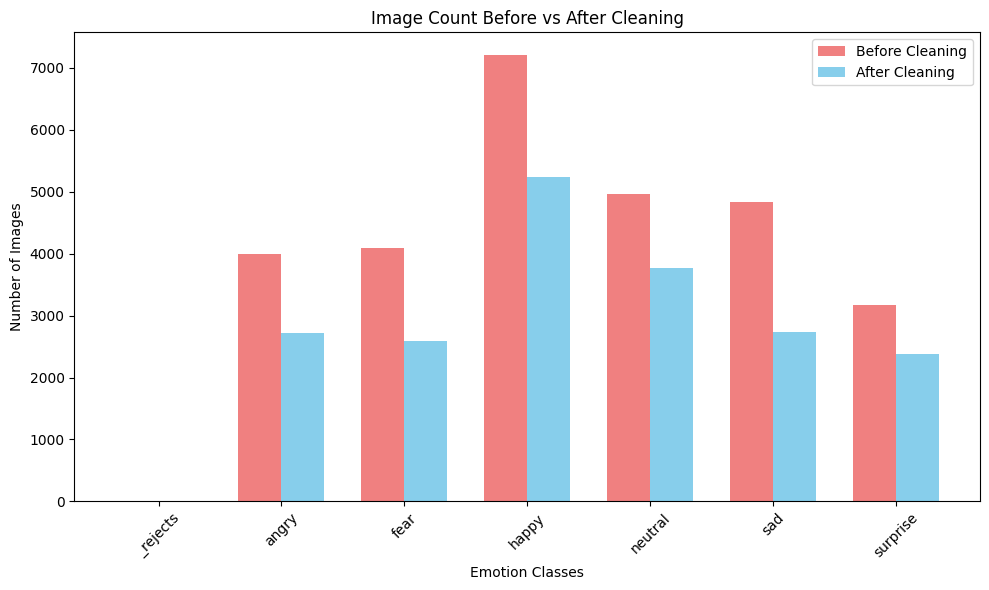

In [25]:
before_path = r"/kaggle/input/amaz-basuru-daniel/Assignment03/data/train"
after_path  = r"/kaggle/input/amaz-basuru-daniel/Assignment03/new_data/train"

before_counts = count_images(before_path)
after_counts  = count_images(after_path)

all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]
x = np.arange(len(all_classes))  
width = 0.35  
plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()





it seems that almost one third of the data has been deleted with the haars cascade it might make it harder for our machine learning models to pick up the patterns in the data . another data foltering method should be used 

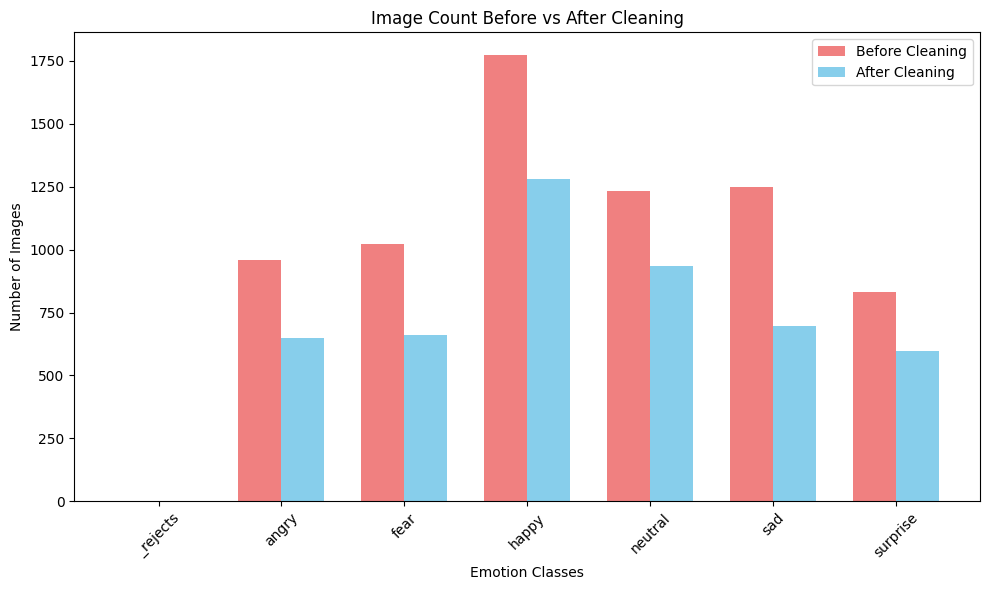

In [26]:
before_path = r"/kaggle/input/amaz-basuru-daniel/Assignment03/data/test"
after_path  = r"/kaggle/input/amaz-basuru-daniel/Assignment03/new_data/test"
before_counts = count_images(before_path)
after_counts  = count_images(after_path)

all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]
x = np.arange(len(all_classes)) 
width = 0.35  
plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Almost one third of the test data has also been deleted. 

Using a mtcnn model to clean the data

In [28]:
pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [29]:
from mtcnn.mtcnn import MTCNN

img_path = image_paths[-1] 
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(img_path)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector = MTCNN()
results = detector.detect_faces(rgb)

for r in results:
    x, y, w, h = r["box"]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    for (lx, ly) in r["keypoints"].values():
        cv2.circle(img, (lx, ly), 3, (0,0,255), -1)

print(f"Found {len(results)} face(s)")



2025-10-10 20:46:18.084841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760129178.502616      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760129178.629434      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1760129196.508695      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13842 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760129196.509361      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Found 1 face(s)


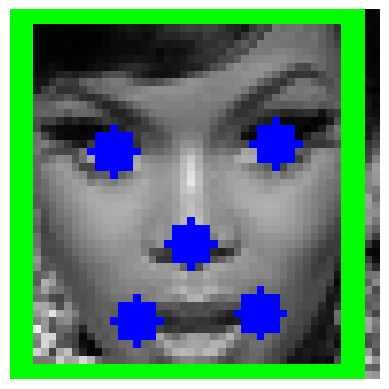

In [30]:
plt.imshow(img)
plt.axis("off")
plt.show()

it seems the picture of the woman which wasn't recognized by the haarscascade is recognized by the MTCNN Architecture 

In [31]:
def rotate_and_crop(img, box, keypoints, eye_target_y=40, out_size=(112,112)):
    (x, y, w, h) = box
    left_eye  = keypoints["left_eye"]
    right_eye = keypoints["right_eye"]
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = math.degrees(math.atan2(dy, dx))
    center = (x + w//2, y + h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    pad = int(0.25 * max(w, h))
    x1 = max(0, x - pad); y1 = max(0, y - pad)
    x2 = min(rotated.shape[1], x + w + pad); y2 = min(rotated.shape[0], y + h + pad)
    crop = rotated[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    return cv2.resize(crop, out_size, interpolation=cv2.INTER_AREA)

These lines have been commented out to save computational time , they were used to filter the dataset

In [ ]:
# in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\train")   
# out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train")
# out_dir.mkdir(parents=True, exist_ok=True)

# detector = MTCNN()
# img_exts = {".jpg"}

# count = 0
# for p in in_dir.rglob("*"):
#     if p not in img_exts:
#         continue

#     bgr = cv2.imread(str(p))
#     if bgr is None:
#         continue
#     rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

#     detections = detector.detect_faces(rgb)
#     for i, det in enumerate(detections):
#         crop = rotate_and_crop(bgr, det["box"], det["keypoints"])
#         if crop is None:
#             continue
#         rel_path = p.relative_to(in_dir)  
#         out_subdir = out_dir / rel_path.parent  
#         out_subdir.mkdir(parents=True, exist_ok=True)

#         out_path = out_subdir / f"{p.stem}_face{i}.jpg"
#         cv2.imwrite(str(out_path), crop)
#         count += 1


# print(f"Saved {count} aligned face crop(s) to: {out_dir}")


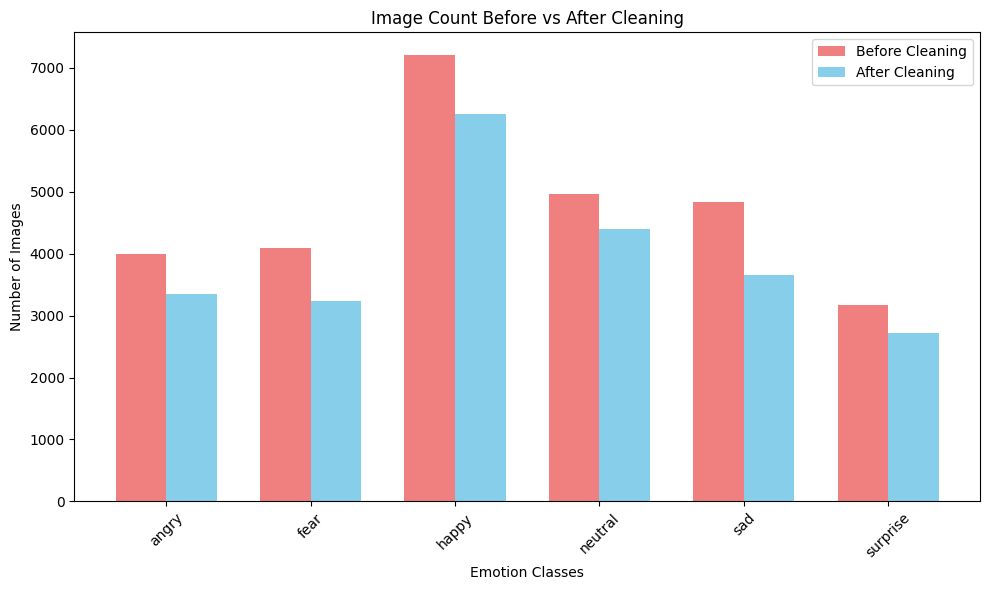

In [32]:
before_path = r"/kaggle/input/amaz-basuru-daniel/Assignment03/data/train"
after_path  = r"/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/train"
before_counts = count_images(before_path)
after_counts  = count_images(after_path)
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]
x = np.arange(len(all_classes)) 
width = 0.35  
plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

A lot less data are delted with use of MTCNN architecture to filter data

These lines have been commented out to save computational time , they were used to filter the dataset

In [ ]:
# in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\data\test")   # << change this
# out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test")
# out_dir.mkdir(parents=True, exist_ok=True)

# count = 0
# for p in in_dir.rglob("*"):
#     if p not in img_exts:
#         continue

#     bgr = cv2.imread(str(p))
#     if bgr is None:
#         continue
#     rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

#     detections = detector.detect_faces(rgb)
#     for i, det in enumerate(detections):
#         crop = rotate_and_crop(bgr, det["box"], det["keypoints"])
#         if crop is None:
#             continue

#         rel_path = p.relative_to(in_dir)  
#         out_subdir = out_dir / rel_path.parent  
#         out_subdir.mkdir(parents=True, exist_ok=True)

#         out_path = out_subdir / f"{p.stem}_face{i}.jpg"
#         cv2.imwrite(str(out_path), crop)
#         count += 1

# print(f"Saved {count} aligned face crop(s) to: {out_dir}")


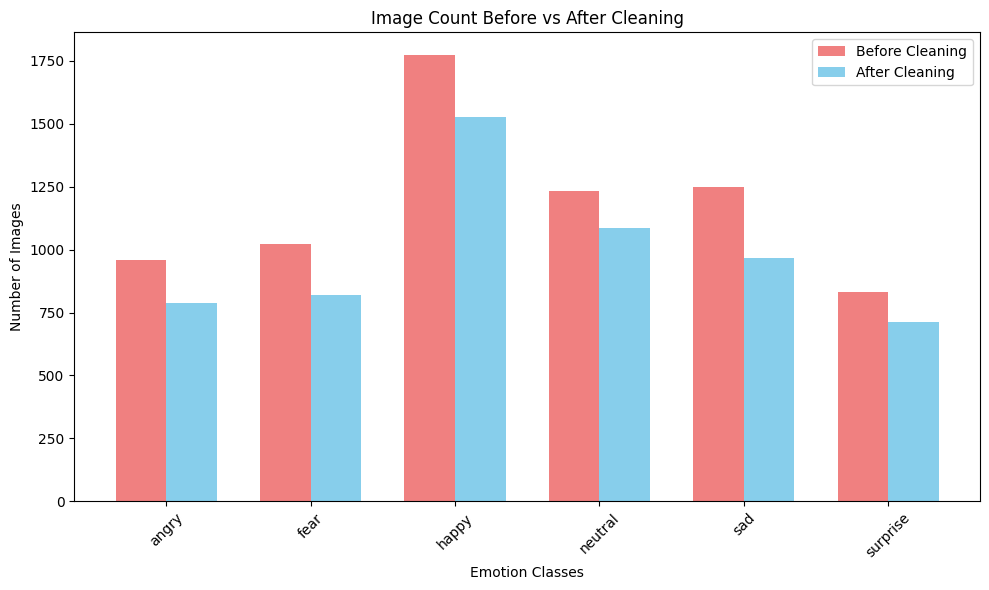

In [33]:
before_path = r"/kaggle/input/amaz-basuru-daniel/Assignment03/data/test"
after_path  = r"/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/test"
before_counts = count_images(before_path)
after_counts  = count_images(after_path)
all_classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
before_values = [before_counts.get(c, 0) for c in all_classes]
after_values  = [after_counts.get(c, 0) for c in all_classes]
x = np.arange(len(all_classes))  
width = 0.35  
plt.figure(figsize=(10,6))
plt.bar(x - width/2, before_values, width, label='Before Cleaning', color='lightcoral')
plt.bar(x + width/2, after_values,  width, label='After Cleaning', color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.title("Image Count Before vs After Cleaning")
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Implementing a Random Forest Model on the Data

Wavelet transformation will be used for feature extraction

In [34]:
def to_uint8(im):
    im = im.astype(np.float32)
    im -= im.min()
    if im.max() > 0:
        im /= im.max()
    return (im * 255).astype(np.uint8)

In [35]:
def resize_to_w(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, (width, int(img.shape[0]*scale)), interpolation=cv2.INTER_AREA)

In [36]:
import pywt


def wavelet_vstack(image_bgr, wavelet="db2", level=1):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    cA, (cH, cV, cD) = pywt.dwt2(gray, wavelet=wavelet)
    cA_v = to_uint8(cA)
    cH_v = to_uint8(np.abs(cH))
    cV_v = to_uint8(np.abs(cV))
    cD_v = to_uint8(np.abs(cD))
    h, w = gray.shape
    cA_v = resize_to_w(cA_v,w)
    cH_v = resize_to_w(cH_v,w)
    cV_v = resize_to_w(cV_v,w)
    cD_v = resize_to_w(cD_v,w)
    orig = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cA_c = cv2.cvtColor(cA_v, cv2.COLOR_GRAY2BGR)
    cH_c = cv2.cvtColor(cH_v, cv2.COLOR_GRAY2BGR)
    cV_c = cv2.cvtColor(cV_v, cv2.COLOR_GRAY2BGR)
    cD_c = cv2.cvtColor(cD_v, cv2.COLOR_GRAY2BGR)

    vs = np.vstack([orig, cA_c, cH_c, cV_c, cD_c])
    return vs





These lines have been commented out to save computational time , they were used to filter the dataset

In [94]:
# in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\train")
# out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train")
# out_dir.mkdir(parents=True, exist_ok=True)
# valid_exts = {".jpg"}
# for p in in_dir.rglob("*"):
#     if p.suffix.lower() in valid_exts:
#         img = cv2.imread(str(p))
#         if img is None: 
#             continue
#         rel_path = p.relative_to(in_dir)
#         save_folder = out_dir / rel_path.parent
#         save_folder.mkdir(parents=True, exist_ok=True)
#         stacked = wavelet_vstack(img, wavelet="db2", level=1)
#         out_path = save_folder / f"{p.stem}_wavelet_stack.jpg"
#         cv2.imwrite(str(out_path), stacked)

# print("Saved vertical stacks to:", out_dir)

Saved vertical stacks to: D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\train


In [95]:

# in_dir  = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn\test")
# out_dir = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\test")
# out_dir.mkdir(parents=True, exist_ok=True)

# valid_exts = {".jpg"}

# for p in in_dir.rglob("*"):
#     if p.suffix.lower() in valid_exts:
#         img = cv2.imread(str(p))
#         if img is None: 
#             continue
#         rel_path = p.relative_to(in_dir)
#         save_folder = out_dir / rel_path.parent
#         save_folder.mkdir(parents=True, exist_ok=True)

#         stacked = wavelet_vstack(img, wavelet="db2", level=1)
#         out_path = save_folder / f"{p.stem}_wavelet_stack.jpg"
#         cv2.imwrite(str(out_path), stacked)

# print("Saved vertical stacks to:", out_dir)


Saved vertical stacks to: D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\wave\test


In [37]:

def extract_wavelet_features(img_path, wavelet="db2", level=1):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (64,64))
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    cA, detail_coeffs = coeffs[0], coeffs[1:]  
    features = [cA.flatten()]
    for (cH, cV, cD) in detail_coeffs:
        features.extend([cH.flatten(), cV.flatten(), cD.flatten()])
    return np.concatenate(features) 


In [38]:

data_dir = Path(r"/kaggle/input/amaz-basuru-daniel/Assignment03/wave/train")

X, y = [], []
for folder in data_dir.iterdir():
    if folder.is_dir():
        label = folder.name
        for img_path in folder.glob("*.jpg"):
            feats = extract_wavelet_features(img_path)
            if feats is not None:
                X.append(feats)
                y.append(label)

X = np.array(X)
y = np.array(y)

print("Feature matrix:", X.shape, "Labels:", y.shape)


Feature matrix: (23625, 4356) Labels: (23625,)


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest Results:\n", classification_report(y_test, rf.predict(X_test)))


Random Forest Results:
               precision    recall  f1-score   support

       angry       0.56      0.19      0.29       564
        fear       0.65      0.17      0.27       540
       happy       0.46      0.89      0.61      1075
     neutral       0.40      0.57      0.47       777
         sad       0.50      0.12      0.20       569
    surprise       0.73      0.55      0.63       495

    accuracy                           0.48      4020
   macro avg       0.55      0.42      0.41      4020
weighted avg       0.53      0.48      0.43      4020



Overall performance of the model is low , however the model performs well on the suprise which itself is not enough to be used in a real world scenario

# Implementing a Base Line CNN Architecture on the Data Set

Implementing a Baseline CNN Model 

In [55]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/train",        
    image_size=(48, 48),   
    batch_size=32,
    label_mode = "categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/test",       
    image_size=(48, 48),
    batch_size=32,
    label_mode = "categorical"
)


Found 23625 files belonging to 6 classes.
Found 5902 files belonging to 6 classes.


Implementing a Baseline CNN Model 

In [56]:
class_names = train_ds.class_names
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [57]:
from tensorflow.keras import layers, models

num_classes = len(class_names)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(48,48,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,294 (1.36 MB)

 Trainable params: 356,294 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model.compile(optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])


In [59]:
history_1 = model.fit(train_ds,validation_data=test_ds,epochs=20)


Epoch 1/20


I0000 00:00:1760129956.574487     119 service.cc:148] XLA service 0x7cc554008d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760129956.579704     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760129956.579722     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760129957.049102     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


 11/739 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1743 - loss: 1.8145

I0000 00:00:1760129960.968015     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


739/739 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - accuracy: 0.2783 - loss: 1.7181 - val_accuracy: 0.4436 - val_loss: 1.4185
Epoch 2/20
739/739 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4287 - loss: 1.4320 - val_accuracy: 0.4839 - val_loss: 1.2916
Epoch 3/20
739/739 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4814 - loss: 1.3034 - val_accuracy: 0.5058 - val_loss: 1.2364
Epoch 4/20
739/739 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5143 - loss: 1.2355 - val_accuracy: 0.5466 - val_loss: 1.1610
Epoch 5/20
739/739 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5398 - loss: 1.1774 - val_accuracy: 0.5571 - val_loss: 1.1398
Epoch 6/20
739/739 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5593 - loss: 1.1334 - val_accuracy: 0.5642 - val_loss: 1.1216
Epoch 7/20
739/739 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5716 - loss: 1.0953 - val_accuracy: 0.5612 - val_loss: 1.1226
Epoch 8/20
739/739 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5882 - loss: 1.0552 - val_accurac

In [60]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2f}")

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5766 - loss: 1.3184
Test accuracy: 0.58


In [61]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

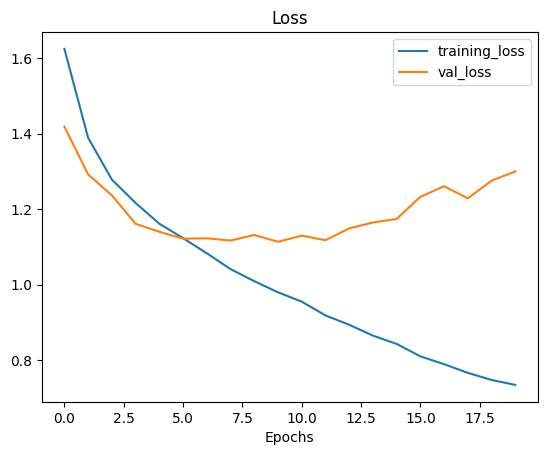

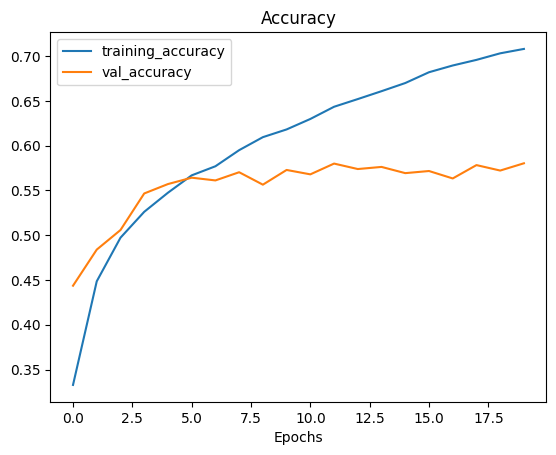

In [62]:
# Check out the loss curves of model_4
plot_loss_curves(history_1)
plt.show()

it seems the baseline model is overfitting the data as the validation accuracy is flattening out after the fifth epoch

# Using the Mini-xception CNN Architectire Extracted from Git Hub

In [63]:
import tensorflow as tf

img_size = (48, 48)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/train",labels="inferred",label_mode="categorical",        
    image_size=img_size,batch_size=batch_size,shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/test", labels="inferred",label_mode="categorical",
    image_size=img_size,batch_size=batch_size,shuffle=False)





Found 23625 files belonging to 6 classes.
Found 5902 files belonging to 6 classes.


In [64]:
def scale_pixels(x, y):
    return tf.cast(x, tf.float32) / 255.0, y



In [65]:
train_ds = train_ds.map(scale_pixels).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(scale_pixels).prefetch(tf.data.AUTOTUNE)

this function was extracted from Git Hub

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
def build_minixception(input_shape, num_classes, l2_reg=0.01):
    """Function for instantiating an Mini-Xception model.

    # Arguments
        input_shape: List corresponding to the input shape
            of the model.
        num_classes: Integer.
        l2_reg. Float. L2 regularization used
            in the convolutional kernels.

    # Returns
        Tensorflow-Keras model.
    """

    regularization = l2(l2_reg)

    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(1, 1),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model


In [70]:
model = build_minixception(input_shape=(48, 48, 3),  num_classes=6)

In [71]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   
    metrics=["accuracy"]
)


In [72]:
history_2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20
)


Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.3409 - loss: 1.8565 - val_accuracy: 0.1854 - val_loss: 2.0057
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4794 - loss: 1.5200 - val_accuracy: 0.4258 - val_loss: 1.7074
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5221 - loss: 1.3975 - val_accuracy: 0.3451 - val_loss: 1.9109
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5521 - loss: 1.3088 - val_accuracy: 0.3950 - val_loss: 1.7661
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5670 - loss: 1.2493 - val_accuracy: 0.4995 - val_loss: 1.3833
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5799 - loss: 1.2067 - val_accuracy: 0.4687 - val_loss: 1.4856
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5958 - loss: 1.1705 - val_accuracy: 0.5105 - val_loss: 1.4075
Epoch 8/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6013 - loss: 1.1444 - 

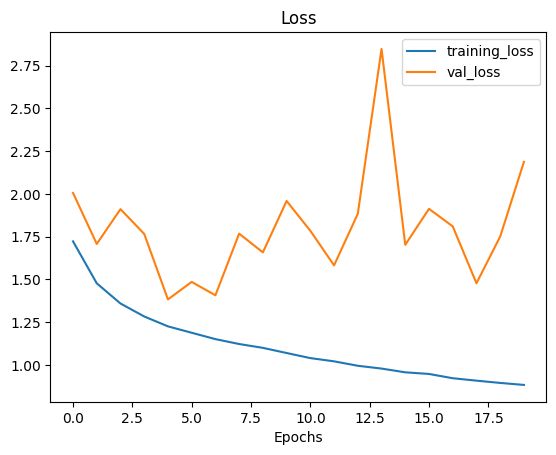

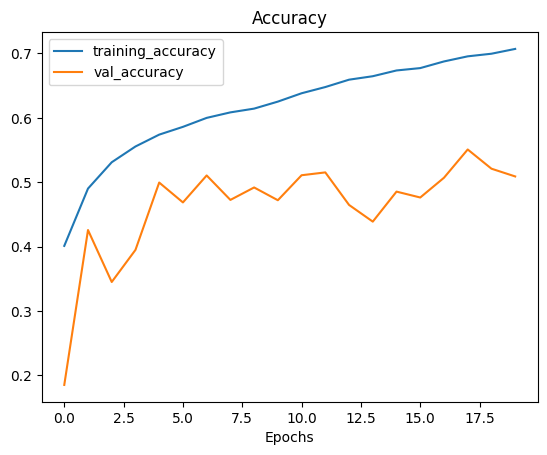

In [73]:
plot_loss_curves(history_2)
plt.show()

It seems the Minixception architecture is not a good fit for our data as the validation set's performance is poor

# Training convnext_tiny.fb_in22k

In [74]:
import random, time, math
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

import timm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [75]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [76]:
#DATA_DIR = Path(r"D:\University\Massey University\2nD year Sem 2\Big Data Processing and Applied Machine Learning\Assignment 03\mtcnn")

TRAIN_DIR = "/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/train"
TEST_DIR  ="/kaggle/input/amaz-basuru-daniel/Assignment03/mtcnnBybasuru/test"

In [77]:
IMG_SIZE = 224
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])



In [78]:
valid_exts = {".jpg"}
def is_image_file(path: str) -> bool:
    return Path(path).suffix.lower() in valid_exts

In [79]:
train_ds = ImageFolder(TRAIN_DIR, transform=train_tfm, is_valid_file=is_image_file)
test_ds  = ImageFolder(TEST_DIR,  transform=test_tfm,  is_valid_file=is_image_file)

In [80]:
CLASSES = train_ds.classes
NUM_CLASSES = len(CLASSES)

In [81]:
labels = np.array(train_ds.targets)
counts = np.array([np.sum(labels == i) for i in range(NUM_CLASSES)], dtype=np.float32)
print("Per-class counts:", dict(zip(CLASSES, counts.astype(int))))


Per-class counts: {'angry': 3351, 'fear': 3244, 'happy': 6249, 'neutral': 4407, 'sad': 3653, 'surprise': 2721}


In [82]:
weights = counts.sum() / (counts * NUM_CLASSES)
class_weights = torch.tensor(weights, dtype=torch.float32, device = DEVICE)
print("Class weights:", dict(zip(CLASSES, weights.round(3))))

Class weights: {'angry': 1.175, 'fear': 1.214, 'happy': 0.63, 'neutral': 0.893, 'sad': 1.078, 'surprise': 1.447}


In [83]:

BATCH_SIZE   = 64
NUM_WORKERS  = 2
sample_w = weights[labels]
sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [84]:

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

In [85]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [86]:
BACKBONE = "convnext_tiny.fb_in22k"
model = timm.create_model(BACKBONE, pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)
BASE_LR = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=3e-6)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

/tmp/ipykernel_37/2529362844.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


In [87]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

In [88]:
def train_one_epoch(model, loader, criterion):
    model.train()
    total_loss, total_acc, total_n = 0.0, 0.0, 0

    pbar = tqdm(loader, leave=False, desc="train")
    for x, y in pbar:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss   = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = accuracy_from_logits(logits, y)
        bs  = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs

        pbar.set_postfix(loss=f"{total_loss/total_n:.3f}", acc=f"{total_acc/total_n:.3f}")

    return total_loss/total_n, total_acc/total_n

In [89]:
@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    pbar = tqdm(loader, leave=False, desc="val  ")
    for x, y in pbar:
        x, y   = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss   = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        bs  = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_n    += bs
        pbar.set_postfix(loss=f"{total_loss/total_n:.3f}", acc=f"{total_acc/total_n:.3f}")
    return total_loss/total_n, total_acc/total_n

In [90]:
EPOCHS   = 20
PATIENCE = 5
best_val_acc = -1.0
wait = 0
history = []
print(f"Training on {DEVICE} for {EPOCHS} epochs …")
for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion)
    va_loss, va_acc = eval_one_epoch(model,  test_loader,  criterion)  
    scheduler.step()
    history.append({"ep": ep, "tr_loss": tr_loss, "tr_acc": tr_acc,
                    "va_loss": va_loss, "va_acc": va_acc})
    print(f"Ep {ep:02d} | train {tr_loss:.3f}/{tr_acc:.3f} "
          f"| val {va_loss:.3f}/{va_acc:.3f} | time {time.time()-t0:.1f}s")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        wait = 0
        torch.save({"model": model.state_dict(), "classes": CLASSES}, "best_model.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break

print("Best val acc:", best_val_acc)

Training on cuda for 20 epochs …


train:   0%|          | 0/370 [00:00<?, ?it/s]/tmp/ipykernel_37/1682979769.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


Ep 01 | train 1.466/0.363 | val 1.112/0.573 | time 135.7s


Ep 02 | train 0.961/0.633 | val 0.967/0.633 | time 133.8s


Ep 03 | train 0.793/0.702 | val 0.938/0.664 | time 133.8s


Ep 04 | train 0.656/0.758 | val 0.988/0.666 | time 133.8s


Ep 05 | train 0.555/0.802 | val 1.006/0.687 | time 133.6s


Ep 06 | train 0.415/0.852 | val 0.989/0.693 | time 133.6s


Ep 07 | train 0.317/0.886 | val 1.044/0.693 | time 133.6s


Ep 08 | train 0.238/0.917 | val 1.228/0.690 | time 133.8s


Ep 09 | train 0.177/0.937 | val 1.242/0.695 | time 133.7s


Ep 10 | train 0.144/0.950 | val 1.324/0.699 | time 133.7s


Ep 11 | train 0.112/0.961 | val 1.440/0.696 | time 133.5s


Ep 12 | train 0.093/0.966 | val 1.411/0.710 | time 133.6s


Ep 13 | train 0.074/0.973 | val 1.459/0.706 | time 133.4s


Ep 14 | train 0.061/0.979 | val 1.559/0.706 | time 133.5s


Ep 15 | train 0.053/0.982 | val 1.542/0.706 | time 133.5s


Ep 16 | train 0.043/0.985 | val 1.596/0.699 | time 133.3s


Ep 17 | train 0.033/0.989 | val 1.698/0.713 | time 133.5s


Ep 18 | train 0.026/0.990 | val 1.783/0.712 | time 133.2s


Ep 19 | train 0.023/0.991 | val 1.857/0.711 | time 133.3s


Ep 20 | train 0.021/0.992 | val 1.827/0.713 | time 132.8s
Best val acc: 0.7133175195657129


In [91]:
ckpt = torch.load("best_model.pt", map_location=DEVICE)



In [92]:

all_preds, all_true = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, leave=False):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

print("TEST RESULTS")
print(classification_report(all_true, all_preds, target_names=CLASSES, digits=2))


TEST RESULTS
              precision    recall  f1-score   support

       angry       0.59      0.69      0.63       788
        fear       0.65      0.52      0.58       820
       happy       0.90      0.88      0.89      1528
     neutral       0.67      0.69      0.68      1087
         sad       0.56      0.56      0.56       966
    surprise       0.82      0.85      0.84       713

    accuracy                           0.71      5902
   macro avg       0.70      0.70      0.70      5902
weighted avg       0.71      0.71      0.71      5902



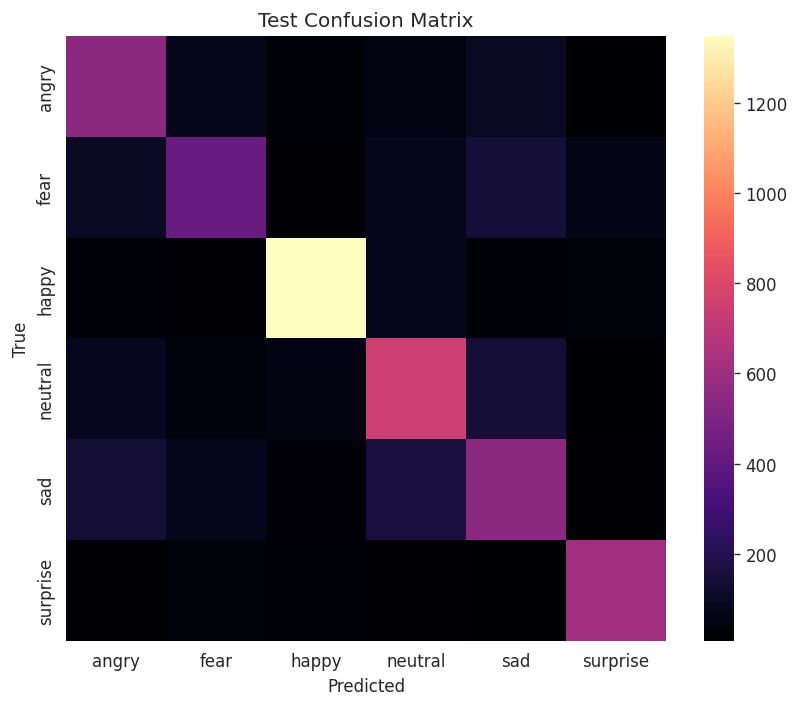

In [93]:
cm = confusion_matrix(all_true, all_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, fmt="d", cmap="magma",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

The Confusion matrix reveals a lot of insights about the diagram, happy and neutral is correctly classified a lot of the times while sad, suprise,angry and fear are not correctly classified as often

The model shows decent performance overall , however it seems that sad is at times confused with neutral and neutral with sad, it is expected to show a normal person in a okay mood as sad . 

In [94]:
def predict_image(img_path: str, model, transform=test_tfm, topk=3):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().ravel()
    idxs = probs.argsort()[::-1][:topk]
    return [(CLASSES[i], float(probs[i])) for i in idxs]


In [97]:
history = pd.DataFrame(history)
history["ep"] = history["ep"].astype(int)


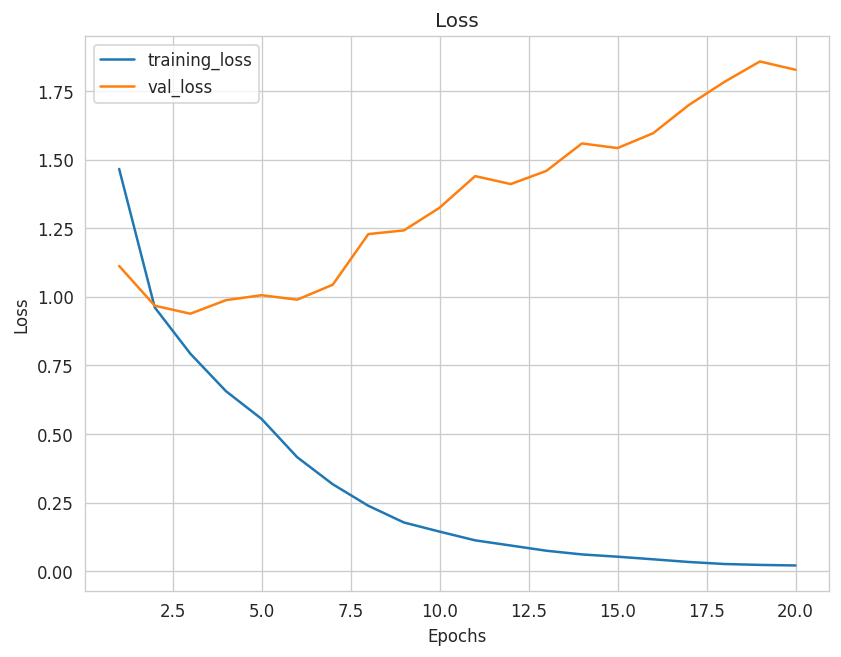

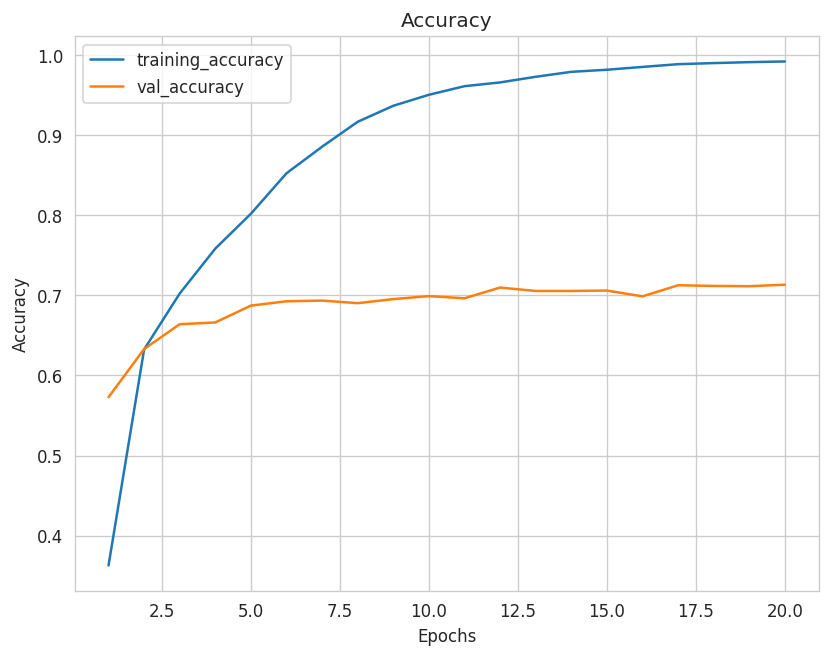

In [98]:
plt.figure(figsize=(8, 6))
plt.plot(history["ep"], history["tr_loss"], label="training_loss")
plt.plot(history["ep"], history["va_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history["ep"], history["tr_acc"], label="training_accuracy")
plt.plot(history["ep"], history["va_acc"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Validation loss seems to have increased after the 8th epoch, and the model has overfit the data as it gets to the 20 th epoch , however model accuracy has improved . 

This model is not a perfect fit for the data however, it is the best performing model out of our tested models

In [99]:
convnext_tiny_fb_in22k = max(history["va_acc"])
base_line = max(history_1.history['val_accuracy'])
mini_xception_algo = max(history_2.history['val_accuracy'])
random_forest = 0.48

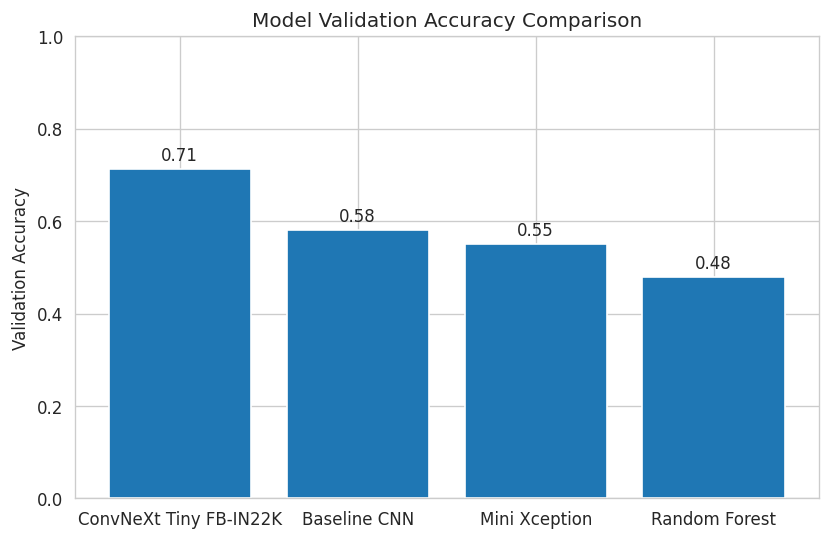

In [100]:
models = ['ConvNeXt Tiny FB-IN22K', 'Baseline CNN', 'Mini Xception', 'Random Forest']
accuracies = [convnext_tiny_fb_in22k, base_line, mini_xception_algo, random_forest]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies)

plt.ylabel('Validation Accuracy')
plt.title('Model Validation Accuracy Comparison')
plt.ylim(0, 1)  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.show()


Mini- Xception model has performed worse than the Baseline CNN model, Convext Tiny FB-IN22K model has performed well even though it overfits the data 

Random Forest model has low accuracy showcasing the superiority of CNN in the field of Computer vision

Onnx will be used to deploy the model in streamlit

In [116]:
import onnxruntime as ort

CKPT_PATH    = "best_model.pt"   
BACKBONE     = "convnext_tiny.fb_in22k"
NUM_CLASSES  = 6
DEVICE       = "cpu"               
model = timm.create_model(BACKBONE, pretrained=False, num_classes=NUM_CLASSES ).to(DEVICE)
model.eval()
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
sd = ckpt["model"]
new_sd = {}
for k, v in sd.items():
    new_sd[k] = v
cfg = getattr(model, "default_cfg", {}) or {}
input_size = cfg.get("input_size", (3, 224, 224))
C, H, W = input_size
IMG_SIZE = (H, W)  
dummy = torch.randn(1, C, H, W, device=DEVICE)

onnx_path = "model_basuru.onnx"
torch.onnx.export(model,dummy,onnx_path,export_params=True,opset_version=17, do_constant_folding=True,input_names=["input"],output_names=["logits"],     
    dynamic_axes={"input":  {0: "batch_size"}, "logits": {0: "batch_size"},},)
print(f"Exported to {onnx_path}")





Exported to model_basuru.onnx


In [118]:
import json

class_dict = {"classes": {"angry", "fear", "happy","neutral","sad","suprise"}}  
class_dict["classes"] = list(class_dict["classes"])
with open("classes.json", "w") as f:
    json.dump(class_dict, f, indent=4)

print("classes.json created ")



classes.json created 


In Conclusion the Transfer learning methods have given the highest accuracy among our experiments, emphasis should be given to the exploration of more CNN architectures 
However given the time and challenges with processing times which had to be overcome during the experimentation stage , CONVEXT TINY FB IN22K Model is picked as the model to be deployed in the final product